# Hyperion Capstone 6

This project will be using a [Random Forest](https://en.wikipedia.org/wiki/Random_forest) machine learning model and the [MNIST dataset of handwritten digits](http://yann.lecun.com/exdb/mnist/) in an attempt to recognise and predict general handwritten digits.

Structure:
- Read data
- Separate data into train, validation, and test subsets
- Create Random forest model
- Tune a parameter
- Analyse the confusion matrix
- Analyse the accuracy, precision, recall, and f1-score

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from mlxtend.data import loadlocal_mnist

## Loading and separating MNIST data-set

The data will be split into a training, validation, and testing subsets. The training and testing subsets exist to isolate the data-set used when training the model from the data-set used to test the performance of the model. This is done to ensure that the model is general enough. If the model was trained on all the data it might begin to "overfit", especially if all the training data is from a single source. Overfitting is when the model becomes very good at predicting the training data due to patterns that may only be present in the training data, but poor at predicting unseen data, which may not show the same patterns.

The validation subset is used when tuning the model. Tuning the model could involve changing parameters based on previous performaces. If these previous runs were tested using the testing data-set, the model has a risk of overfitting to the testing data-set aswell. To solve this and to keep the training and testing datasets separate until the final run, a validation set is generated. Therefore, during tuning, the model is fit using the training data, tested using the validation data, then a final result is generated uing the testing data.

A common training, validation, testing split is 60:20:20. In this example, since the MNIST dataset is already split 85:15, the 3 way split will be 70:15:15.

Training subset: images-(50000, 784), labels-(50000,)
Validation subset: images-(10000, 784), labels-(10000,)
Testing subset: images-(10000, 784), labels-(10000,)


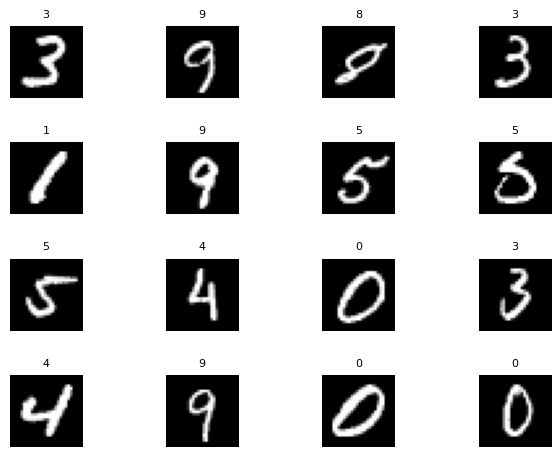

In [2]:
#Loading testing data subset
x_test,y_test = loadlocal_mnist(
    images_path='t10k-images.idx3-ubyte',
    labels_path='t10k-labels.idx1-ubyte'
    )

#Loading training data subset
x_train,y_train = loadlocal_mnist(
    images_path='train-images.idx3-ubyte',
    labels_path='train-labels.idx1-ubyte'
    )

#Random seed to keep everything consistent
r = 34235

#Split training to get a validation subset
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.16666,shuffle=True,random_state=r)

#Data split into 70:15:15 ratio
print(f"Training subset: images-{x_train.shape}, labels-{y_train.shape}")
print(f"Validation subset: images-{x_val.shape}, labels-{y_val.shape}")
print(f"Testing subset: images-{x_test.shape}, labels-{y_test.shape}")

#Reshapes the training data into 50000, 28x28 grayscale images
images = x_train.reshape(50000,28,28)

#Size of grid showing some numbers
grid_size = 4

#Sets up subplots
fig, axs = plt.subplots(grid_size,grid_size,)
fig.tight_layout()
#Plots the first 9 images in the trinaing set
counter = 0
for i in range(grid_size):
    for j in range(grid_size):
        axs[i][j].imshow(images[counter,:,:],cmap='gray')
        axs[i][j].set_title(str(y_train[counter]),fontdict={"fontsize":8})
        axs[i][j].axis('off')
        counter += 1

## Fitting a default Random Forest model

This step will be used as a benchmark on the performace of a random forest model without changing any parameters.

In [3]:
#Generating the random forest model
std_forest = RandomForestClassifier(random_state=r)

#Training the model using the training subset
std_forest.fit(x_train,y_train)

print("Default Random Forest score:",std_forest.score(x_val,y_val))

Default Random Forest score: 0.9681


## Tuning a Random Forest Model

There are many different [parameters](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) that can be modified within the model provided by scikit-learn.

In this example, the `max_depth` parameter will be tested. The `max_depth` parameter determins how may levels of nodes are allowed in each tree within the forest. The more nodes should mean a more precise model, however, this could make the model more prone to overfitting. Therefore, finding the optimal max depth is important when tuning a decision tree ensemble model.

Another important parameter is `n_estimators`. This parameter controls the number of of tree within the forest. This is important as it can also lead to overfitting if too many are present. 

In [4]:
#NOTE: This cell may take a while

#Seed for tuning process
r_tune = 123123

#Empty dataframe to hold all the testing data
tests = pd.DataFrame(columns=["Depth","Training","Validation"])

#Loops through max_depth values of 2 to 21
depths = range(2,22)
for d in depths:
    print(f"TESTING WITH TREES OF DEPTH {d}/{max(depths)}")

    #Initialise and train model with a given max depth
    tune_rand = RandomForestClassifier(max_depth=d,random_state=r_tune)
    tune_rand.fit(x_train,y_train)

    #Get the score using training and validation set
    training = tune_rand.score(x_train,y_train)
    valid = tune_rand.score(x_val,y_val)

    #Appending the dataframe with the test results
    test = pd.DataFrame([[d,training,valid]],columns=tests.columns)
    tests = pd.concat([tests,test],ignore_index=True)

TESTING WITH TREES OF DEPTH 2/21
TESTING WITH TREES OF DEPTH 3/21
TESTING WITH TREES OF DEPTH 4/21
TESTING WITH TREES OF DEPTH 5/21
TESTING WITH TREES OF DEPTH 6/21
TESTING WITH TREES OF DEPTH 7/21
TESTING WITH TREES OF DEPTH 8/21
TESTING WITH TREES OF DEPTH 9/21
TESTING WITH TREES OF DEPTH 10/21
TESTING WITH TREES OF DEPTH 11/21
TESTING WITH TREES OF DEPTH 12/21
TESTING WITH TREES OF DEPTH 13/21
TESTING WITH TREES OF DEPTH 14/21
TESTING WITH TREES OF DEPTH 15/21
TESTING WITH TREES OF DEPTH 16/21
TESTING WITH TREES OF DEPTH 17/21
TESTING WITH TREES OF DEPTH 18/21
TESTING WITH TREES OF DEPTH 19/21
TESTING WITH TREES OF DEPTH 20/21
TESTING WITH TREES OF DEPTH 21/21


The best performing model on the validation set:
Max depth: 18
Accuracy score: 0.9677


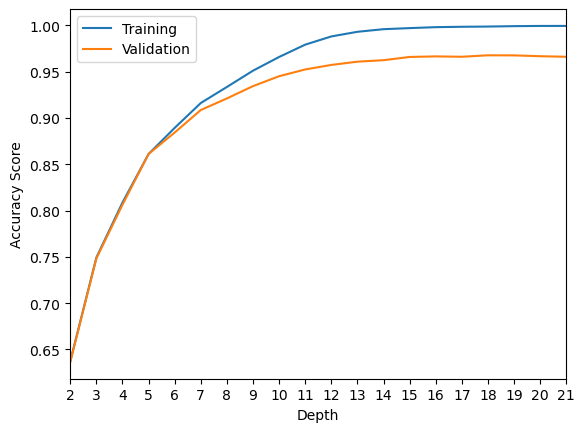

In [5]:

#Plot the test data
ax = tests.plot(x="Depth",ylabel="Accuracy Score",xticks=depths,)
ax.margins(x=0)

#Get the highest accuracy score on the validation data
best_score = tests.Validation.values.max()

#Gets the depth corresponding to that accuracy score
best_depth = int(tests.loc[tests.Validation == best_score].Depth.values)

print("The best performing model on the validation set:")
print("Max depth:",best_depth)
print("Accuracy score:",best_score)

## Final testing on the test subset

After some tests, it was found that the best model had a depth of 18. Though, the graph shows that the model is starting to produce a constant accuracy value for both the training and validation data. Therefore, investing more time to check whether even deeper trees will make a significant difference are probably not worth it. 

Another thing to note is that fact that the training data gives a better accuracy score for almost all tests. This is expected as the model is trying to fit to this exact data and is an example of overfitting compared to the validation data.

Next, after carrying out a final test with these parameters on the testing data, the confusion matrix and different scoring metrics will be explored. 

The confusion matrix is a simple visualisation to show how well the model was at predicting each class in the classification. Each axis of the matrix will represent the true values and the predicted values. In this example, the matrix will be a 10x10 since the model can predict numbers from 0 to 9 for each image. The matrix will represent what the model predicted compared to what the actual value was.

In [6]:
#Initialising the random forest with the best parameters
final_rand = RandomForestClassifier(max_depth=18,random_state=r_tune)
final_rand.fit(x_train,y_train)

#Getting predictions for all the test data
y_pred = final_rand.predict(x_test)

- The class that was the hardest to predict was 5
- The model mistook 4 for a 9 the most out of any specific guess
- The model was the best at predicting the value 1


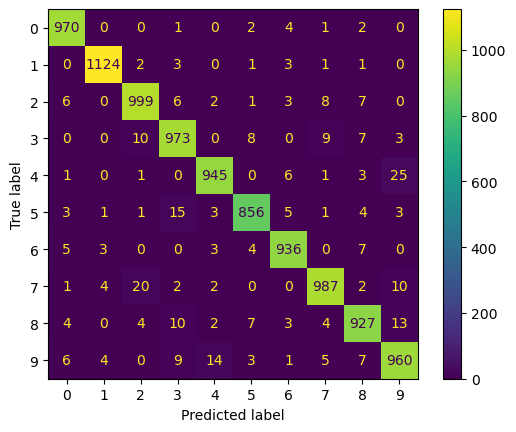

In [7]:

#Generating the confusion matrix comparing the test set labels with the predicted labels
matrix = confusion_matrix(y_test,y_pred)

#Converting the matrix into a format that can be plotted
matrix_plot = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=[0,1,2,3,4,5,6,7,8,9])
matrix_plot.plot()

#Gets a list of correct guesses
correct = [matrix[i][j] for i in range(10) for j in range(10) if j == i ]

#Gets a list of all the incorrect guesses
incorrect = [matrix[i][j] for i in range(10) for j in range(10) if j != i ]

#Finds the class that had the least number of correct guesses
worst_class_correct = correct.index(min(correct))
best_class_correct = correct.index(max(correct))

#Finds the pair of classes that were predicted wrong the most times
worst_true,worst_pred = np.where(matrix == max(incorrect))


print("- The class that was the hardest to predict was",worst_class_correct)
print(f"- The model mistook {int(worst_true)} for a {int(worst_pred)} the most out of any specific guess")
print("- The model was the best at predicting the value",best_class_correct)

## Analysing different score metrics

There are a many different ways to judge whether a model performed well or not. In this example, accuracy, precision, recall, and f1 scores will be looked at. 


For each classification, there are 4 different outcomes that can happen, true positive, true negative, false positive, false negative. For simplicity, assume there are 2 possible classes, X and Y. In this specific case, the true value is X:
- <span style="color:green">True positive (TP)</span>: When the model correctly predicts X IS X
- <span style="color:green">True negative (TN)</span>: When the model correctly predicts X IS NOT Y
- <span style="color:red">False positive (FP)</span>: When the model incorrectly predicts X IS Y
- <span style="color:red">False negative (FN)</span>: When the model incorrectly predicts X IS NOT X

**Accuracy:** This score is the ratio of true predictions compared to all predictions.
$$
A = \frac{TP+TN}{TP+TN+FP+FN}
$$
**Precision:** This is the ratio of true positives compared to all positive predictions.
$$
P = \frac{TP}{TP+FP}
$$
**Recall:** This is the ratio of true positives compared to all actual positive answers.
$$
R = \frac{TP}{TP+FN}
$$
**F1-Score:** This is the harmonic mean of the precision and recall metrics
$$
F = \frac{2\cdot P \cdot R}{P + R}
$$


In [8]:

avg = 'macro'

#Calculates different accuracy scores
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,average=avg)
recall = recall_score(y_test,y_pred,average=avg)
f1 = f1_score(y_test,y_pred,average=avg)

print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F1-Score:",f1)

Accuracy: 0.9677
Precision: 0.9675158185075746
Recall: 0.9673791597127204
F1-Score: 0.967427591307086
